In [22]:
import mne
import warnings
import moabb
import numpy as np
import matplotlib.pyplot as plt
from moabb.datasets import Lee2019_MI
from moabb.paradigms import LeftRightImagery, SSVEP
from neuroxai.utils import topography
from neuroxai.explanation import BrainExplainer

moabb.set_log_level("info")
warnings.filterwarnings("ignore")

## Load Dataset

**Dataset Description** [link](https://doi.org/10.1093/gigascience/giz002)

EEG signals were recorded with a sampling rate of 1,000 Hz and collected with 62 Ag/AgCl electrodes. The EEG amplifier used in the experiment was a BrainAmp (Brain Products; Munich, Germany). The channels were nasion-referenced and grounded to electrode AFz. Additionally, an EMG electrode recorded from each flexor digitorum profundus muscle with the olecranon used as reference. The EEG/EMG channel configuration and indexing numbers are described in Fig. 1. The impedances of the EEG electrodes were maintained below 10 k during the entire experiment.

MI paradigm The MI paradigm was designed following a well-established system protocol. For all blocks, the first 3 s of each trial began with a black fixation cross that appeared at the center of the monitor to prepare subjects for the MI task. Afterwards, the subject performed the imagery task of grasping with the appropriate hand for 4 s when the right or left arrow appeared as a visual cue. After each task, the screen remained blank for 6 s (± 1.5 s). The experiment consisted of training and test phases; each phase had 100 trials with balanced right and left hand imagery tasks. During the online test phase, the fixation cross appeared at the center of the monitor and moved right or left, according to the real-time classifier output of the EEG signal.

In [3]:
ch_names = ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6',
            'T7', 'C3', 'Cz', 'C4', 'T8', 'TP9', 'CP5', 'CP1', 'CP2', 'CP6', 'TP10',
            'P7', 'P3', 'Pz', 'P4', 'P8', 'PO9', 'O1', 'Oz', 'O2', 'PO10', 'FC3', 'FC4',
            'C5', 'C1', 'C2', 'C6', 'CP3', 'CPz', 'CP4', 'P1', 'P2', 'POz', 'FT9', 'FTT9h',
            'TTP7h', 'TP7', 'TPP9h', 'FT10', 'FTT10h', 'TPP8h', 'TP8', 'TPP10h',
            'F9', 'F10', 'AF7', 'AF3', 'AF4', 'AF8', 'PO3', 'PO4']
class_names = ['right_hand', 'left_hand']

In [4]:
dataset = Lee2019_MI()
sampling_rate = 1000
subject_idxs = [33]
paradigm = LeftRightImagery()
x, labels, meta = paradigm.get_data(dataset=dataset, subjects=[subject_idxs[0]])

In [5]:
train_x, test_x = x[meta['session'] == '0'], x[meta['session'] == '1']
train_y, test_y = labels[meta['session'] == '0'], labels[meta['session'] == '1']
train_y, test_y = np.array([class_names.index(label) for label in train_y]), \
                  np.array([class_names.index(label) for label in test_y])

## Preprocessing

Preprocessing was performed on the EEG signals.

In [6]:
rfreq = 250

In [7]:
info = mne.create_info(ch_names=ch_names, sfreq=sampling_rate, ch_types='eeg')
train_raw, test_raw = mne.EpochsArray(train_x, info=info), mne.EpochsArray(test_x, info=info)

In [8]:
train_raw.resample(rfreq)
train_raw.filter(l_freq=1, h_freq=40, fir_design='firwin', verbose=False)

test_raw.resample(rfreq)
test_raw.filter(l_freq=1, h_freq=40, fir_design='firwin', verbose=False)

<EpochsArray | 100 events (all good), 0 – 3.996 s (baseline off), ~47.4 MB, data loaded,
 '1': 100>

In [9]:
train_x, test_x = train_raw.get_data(), test_raw.get_data()

In [10]:
train_y.shape

(100,)

## FBCSP

FBCSP stands for Filter Bank Common Spatial Pattern, an algorithm used in the field of Brain-Computer Interfaces (BCI) to analyze and classify EEG signals. This method decomposes EEG signals into multiple frequency bands and applies Common Spatial Pattern (CSP) to each band to extract spatial features related to specific brain activities, such as motor imagery. These features are then processed by classification algorithms to infer the user's intent or state.

FBCSP is particularly effective in motor imagery-based BCI systems, demonstrating high accuracy by integrating information across multiple frequency bands to analyze the complex patterns of brain activity. This facilitates efficient interaction between users and computers in various applications.


In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from mne.decoding import CSP
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.feature_selection import mutual_info_classif
from scipy.signal import butter, lfilter


def butter_bandpass_filter(signal, low_cut, high_cut, fs, order=5):
    if low_cut == 0:
        low_cut = 0.5
    nyq = 0.5 * fs
    low = low_cut / nyq
    high = high_cut / nyq
    b, a = butter(order, [low, high], btype='band')
    y = lfilter(b, a, signal, axis=-1)
    return y


class FBCSP(object):
    # Filter Bank Common Spectral Pattern
    def __init__(self, sampling_rate, n_components, n_select):
        self.sampling_rate = sampling_rate
        self.select_k = SelectKBest(mutual_info_classif, k=n_select)
        self.scaler = StandardScaler()
        self.low_cut, self.high_cut, self.interval = 4, 40, 4
        self.bands = np.arange(self.low_cut, self.high_cut, self.interval)
        self.csp_list = {
            '{}-{}'.format(band, band+self.interval):
                CSP(n_components=n_components) for band in self.bands
        }
        self.classifier = LinearDiscriminantAnalysis()

    def train(self, x, y):
        # [stage 1, 2] => acquire and combine features of different frequency bands
        x = self.temporal_spatial_filtering(x, y, train=True)

        # [stage 3] : band selection => get the best k features base on mutual information algorithm
        x = self.select_k.fit_transform(x, y)

        # [stage 4] : classification
        x = self.scaler.fit_transform(x)
        self.classifier.fit(x, y)

    def predicate(self, x):
        # [stage 1, 2] => acquire and combine features of different frequency bands
        x = self.temporal_spatial_filtering(x, train=False)

        # [stage 3] : band selection => get the best k features base on mutual information algorithm
        x = self.select_k.transform(x)

        # [stage 4] : classification
        x = self.scaler.transform(x)
        out, prob = self.classifier.predict(x), \
                    self.classifier.predict_proba(x)
        return out, prob

    def temporal_spatial_filtering(self, x, y=None, train=True):
        new_x = []
        for band in self.bands:
            start_band, end_band = band, band + self.interval

            # [stage 1] : temporal filtering
            x_filter = butter_bandpass_filter(signal=x,
                                              low_cut=start_band, high_cut=end_band,
                                              fs=self.sampling_rate)

            # [stage 2] : spectral filtering
            try:
                if train:
                    csp = self.csp_list['{}-{}'.format(start_band, end_band)]
                    x_filter = csp.fit_transform(x_filter, y)
                    self.csp_list['{}-{}'.format(start_band, end_band)] = csp
                else:
                    csp = self.csp_list['{}-{}'.format(start_band, end_band)]
                    x_filter = csp.transform(x_filter)
            except np.linalg.LinAlgError:
                del self.csp_list['{}-{}'.format(start_band, end_band)]
                continue
            except KeyError:
                continue

            new_x.append(x_filter)

        new_x = np.concatenate(new_x, axis=1)
        return new_x

In [12]:
model = FBCSP(
    sampling_rate=rfreq,
    n_components=8,
    n_select=10
)

In [13]:
model.train(x=train_x, y=train_y)

In [14]:
out, prob = model.predicate(x=test_x)

In [15]:
from sklearn.metrics import classification_report

print(classification_report(y_true=test_y, y_pred=out))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90        50
           1       0.90      0.90      0.90        50

    accuracy                           0.90       100
   macro avg       0.90      0.90      0.90       100
weighted avg       0.90      0.90      0.90       100



## NeuroXAI

**Algorithm Description** [link](https://doi.org/10.1016/j.eswa.2024.125364)

Electroencephalogram (EEG)-based applications often require numerous channels to achieve high performance, which limits their widespread use. Various channel selection methods have been proposed to identify minimum EEG channels without compromising performance. However, most methods are limited to specific data paradigms or prediction models. We propose NeuroXAI, a novel method that identifies channel importance regardless of the type of EEG application. It integrates the surrogate analysis algorithm to optimize EEG signals and the data sampling algorithm, which effectively selects from highly voluminous EEG data. The efficacy of channel selection via the proposed method was evaluated through three datasets acquired under different paradigms (motor imagery, steady-state visually evoked potentials, and event-related potentials). On datasets based on these paradigms, NeuroXAI-based channel selection reduced the number of channels while maintaining or enhancing performance. The advantages of the proposed method include enhanced performance, robustness over varying data paradigms and the type of prediction model. The XAI technique enables intuitive interpretation of the constructed model operation, making it applicable in various fields such as model debugging and model interpretation. NeuroXAI has the potential to be used as a practical tool to develop better EEG applications.

In [16]:
class WrapperFBCSP(object):
    def __init__(self, model):
        super().__init__()
        self.model = model
    
    def predicate_prob(self, x):
        _, prob = self.model.predicate(x)
        return prob

model_wrapper = WrapperFBCSP(model=model)

In [17]:
explainer = BrainExplainer(class_names=class_names, kernel_width=25)
idx2chn = {i: ch_name for i, ch_name in enumerate(ch_names)}

### 1. NeuroXAI for individual EEG samples

The result of applying NeuroXAI to data sample 1

In [18]:
sample_idx = 1
sample_x, sample_y = train_x[sample_idx], train_y[sample_idx]
print('Data Shape : ({}, {})'.format(sample_x.shape[0], sample_x.shape[1]))

Data Shape : (62, 1000)


In [19]:
num_samples = 1000           # As the value of num_sample increases, the learning speed improves.
replacement_method = 'mean' 
label_idx_list = [i for i, _ in enumerate(class_names)]
exp = explainer.explain_instance(data=sample_x,
                                 classifier_fn=model_wrapper.predicate_prob,
                                 labels=[sample_y],
                                 num_samples=num_samples,
                                 replacement_method=replacement_method)

In [20]:
ch_im = {idx2chn[ch_idx]: ch_im for ch_idx, ch_im in exp.as_list(label=sample_y)}
print(ch_im)

{'C3': 0.14632602239971107, 'CP2': 0.13801256528437092, 'C4': 0.08438214149268893, 'CP5': 0.08302902512107302, 'C2': -0.06161058866983102, 'TPP9h': 0.05872135368168135, 'FC3': -0.05460527435618273, 'F4': 0.0532043093260773, 'FTT9h': -0.05248510244939439, 'FC4': 0.05216035108334462, 'Cz': 0.05126138030928061, 'PO10': 0.05046234800640793, 'FC2': 0.04911560881917744, 'P3': -0.0488019834229511, 'Fz': 0.04872456333756237, 'CPz': 0.04511150937457771, 'PO9': 0.04094701882571521, 'CP4': -0.038506912267817356, 'FTT10h': -0.0363645412452437, 'O1': -0.03330628928316793, 'FT10': -0.030282696690222734, 'TP8': -0.029214976244979388, 'O2': -0.028470118131534567, 'TPP10h': 0.027689629864276744, 'FT9': -0.024758556775140904, 'P2': 0.023733014754581224, 'TP9': 0.023724733836732327, 'F8': 0.021078895032817076, 'F3': -0.01968263200792436, 'CP6': 0.019447459731290827, 'AF3': -0.018850383263648664, 'AF4': 0.01839519532955213, 'C5': -0.017471160850045953, 'FC5': -0.017164235243881134, 'POz': 0.01698421036021

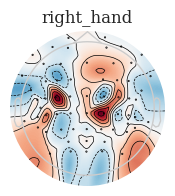

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(2, 3))
topography(ch_im, title=class_names[sample_y], ax=axes)
plt.show()

### 2. NeuroXAI for entire EEG sample

#### Channel importance based on NeuroXAI for each class

In [24]:
from neuroxai.explanation import GlobalBrainExplainer
num_samples = 1000           # As the value of num_sample increases, the learning speed improves.
replacement_method = 'mean' 

g_exp = GlobalBrainExplainer(explainer=explainer)
g_exp.explain_instance(x=train_x, y=train_y,
                       classifier_fn=model_wrapper.predicate_prob,
                       num_samples=num_samples,
                       replacement_method=replacement_method)

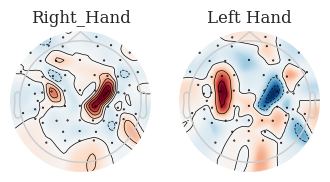

In [25]:
from neuroxai.explanation import GlobalBrainExplainer
class_ch_im = g_exp.explain_classes_channel_importance()
class1_ch_im = {idx2chn[ch_idx]: ch_im for ch_idx, ch_im in class_ch_im['right_hand'].items()}
class2_ch_im = {idx2chn[ch_idx]: ch_im for ch_idx, ch_im in class_ch_im['left_hand'].items()}

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(4, 2))
topography(class1_ch_im, title='Right_Hand', ax=axes[0])
topography(class2_ch_im, title='Left Hand', ax=axes[1])
plt.show()

#### Global Channel importance based on NeuroXAI

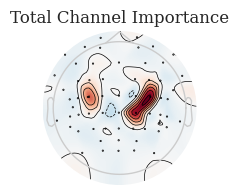

In [26]:
from neuroxai.explanation import GlobalBrainExplainer
g_ch_im = g_exp.explain_global_channel_importance()
g_ch_im = {idx2chn[ch_idx]: ch_im for ch_idx, ch_im in g_ch_im.items()}
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(2, 2))
topography(g_ch_im, title='Total Channel Importance', ax=ax)
plt.show()